# Investigate reasons for breakpoints in the supposedly non-recombinant Nextclade subset

(This is the subset used in the cophylogeny plot)

In [2]:
import sys
import datetime
import shutil
import gzip
import tempfile
import os
import numpy as np

# install sc2ts using python -m pip install git+https://github.com/jeromekelleher/sc2ts
# where python is the python running in your jupytyer notebook (find this by
#import sys; print(sys.executable)
import tskit
import tszip
import sc2ts

# Look for most stuff in the root dir - assumes we are running within `notebooks`
sys.path.append("..")

import utils



/Users/yan/Documents/GitHub/sc2ts/sc2ts/inference.py:917: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_indexes_of(array, values):


In [4]:
ts_dir = "../data"
sc2ts_filename = "upgma-full-md-30-mm-3-2021-06-30-recinfo2-gisaid-il.ts.tsz"

sc2ts_arg, basetime = utils.load_tsz(ts_dir, sc2ts_filename)

NB: For the various rounds of simplification we use filter_nodes=False so that
we keep the same node IDs

In [6]:
nx_fn = "nextstrain_ncov_gisaid_global_all-time_timetree-2023-01-21.nex"
with tempfile.TemporaryDirectory() as tmpdir:
    with gzip.open("../data/" + nx_fn + ".gz") as f_in:
        new_fn = os.path.join(tmpdir, nx_fn)
        with open(new_fn, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
        nextstrain_ts_tmp = sc2ts.newick_from_nextstrain_with_comments(
            sc2ts.extract_newick_from_nextstrain_nexus(new_fn),
            min_edge_length=0.0001 * 1/365,
            span=sc2ts_arg.sequence_length,
        )
        # Remove "samples" without names
        keep = [n.id for n in nextstrain_ts_tmp.nodes() if n.is_sample() and "strain" in n.metadata]
        nx_ts = nextstrain_ts_tmp.simplify(keep)

# Slow step: find the samples in sc2ts_arg.ts also in nextstrain.ts, and subset
sc2ts_its, nxstr_its = sc2ts.subset_to_intersection(
    sc2ts_arg, nx_ts, filter_sites=False, keep_unary=True, filter_nodes=False,
)


In [7]:
print("num samples in ARG vs Nextstrain tree:", sc2ts_its.num_samples, nxstr_its.num_samples)

num samples in each 187 180


In [8]:
tree = sc2ts_its.first()
untouched_by_recomb = []
for sample in sc2ts_its.samples():
    u = sample
    affected_by_recomb = False
    while u != -1:
        e = sc2ts_its.edge(tree.edge(u))
        if e.left != 0 or e.right != sc2ts_its.sequence_length:
            affected_by_recomb = True
            break
        u = tree.parent(u)
    if not affected_by_recomb:
        untouched_by_recomb.append(sample)

In [9]:
keep = [s for s in sc2ts_its.samples() if s not in set(untouched_by_recomb)]
simp = sc2ts_its.simplify(keep, keep_unary=True, filter_nodes=False)
print(simp.num_trees, "trees in the simplified ARG")
print(simp.num_samples, "samples touched by a recombination in the simplified ARG")

8 trees in the simplified ARG
29 samples touched by a recombination in the simplified ARG


Plot the trees out

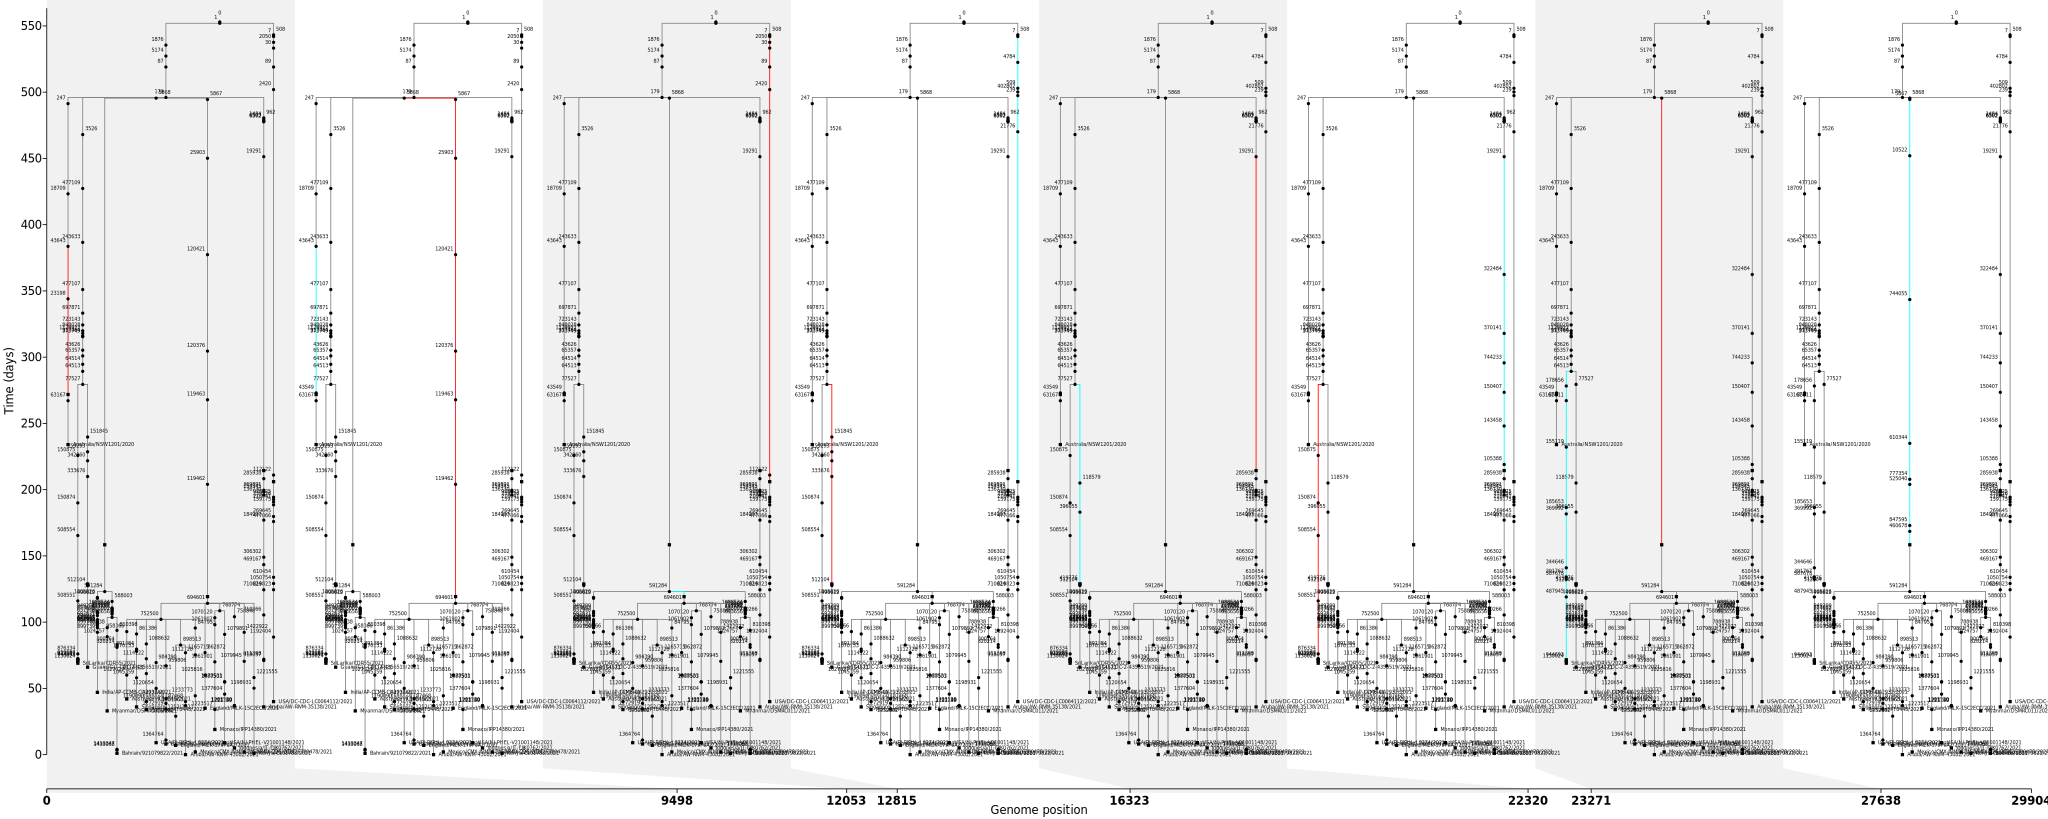

In [11]:
import collections

style = ".node .lab {font-size:6px} .leaf .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
style += ".edge {stroke: grey}"
e_out = collections.defaultdict(set)
e_in = collections.defaultdict(set)
for tree_id, ed in enumerate(simp.edge_diffs()):
    if ed.interval.left != 0:
        for i in ed.edges_in:
            e_in[tree_id].add((i.parent, i.child))
    for o in ed.edges_out:
        e_out[tree_id - 1].add((o.parent, o.child))
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: red}}"
    for tree, edges in e_out.items()
    for c in edges])
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: cyan}}"
    for tree, edges in e_in.items()
    for c in edges])

shown_nodes = {u for tree in simp.trees() for u in tree.nodes()}
node_labels = {u: (simp.node(u).metadata.get("strain", "") if simp.node(u).is_sample() else u) for u in shown_nodes}
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)

We can collapse some nodes here: 694601 is the obvious clonal MRCA here to collapse

In [13]:
# Check clonal
s = set(u for u in simp.first().samples(694601))
for tree in simp.trees():
    assert s == set(u for u in tree.samples(694601))

style += (
    # Hide all nodes descending from node 4. We then treat node 4 as a summary node
    ".n694601 > .node {display: none}"
    
    # Use clipping & scaling to change the symbol for node 4 into a summary triangle
    ".n694601 > .sym {clip-path: polygon(50% 50%, 75% 75%, 25% 75%); transform: scale(8.0, 8.0)}"
    
    # Make the font bigger for this summary node label
    ".n694601 > .lab {transform: rotate(90deg) translate(100px); font-size: 16px}"
)
node_labels[694601] = f"{len(s)} samples"


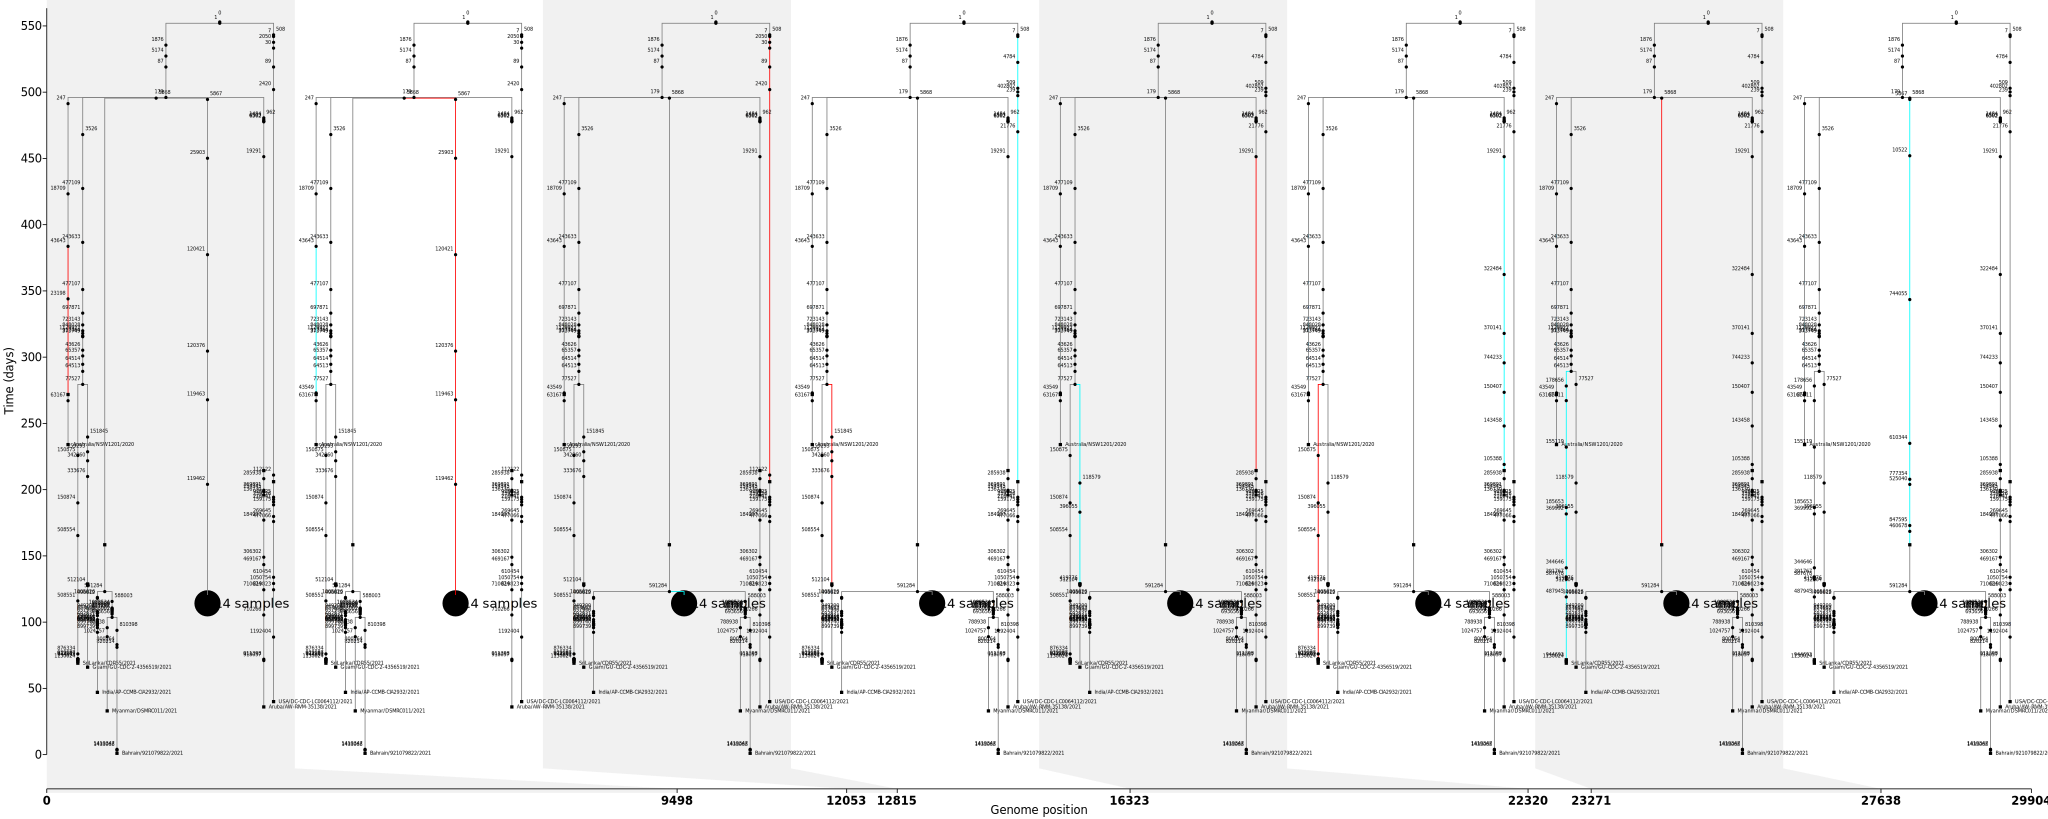

In [14]:
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)

A semi-hand-drawn version of the ARG implied by the above is at `nxstr-simplified-ARG.svg`. This makes it easier to see that the recombinations are all between close relatives (and often do not change the topology)

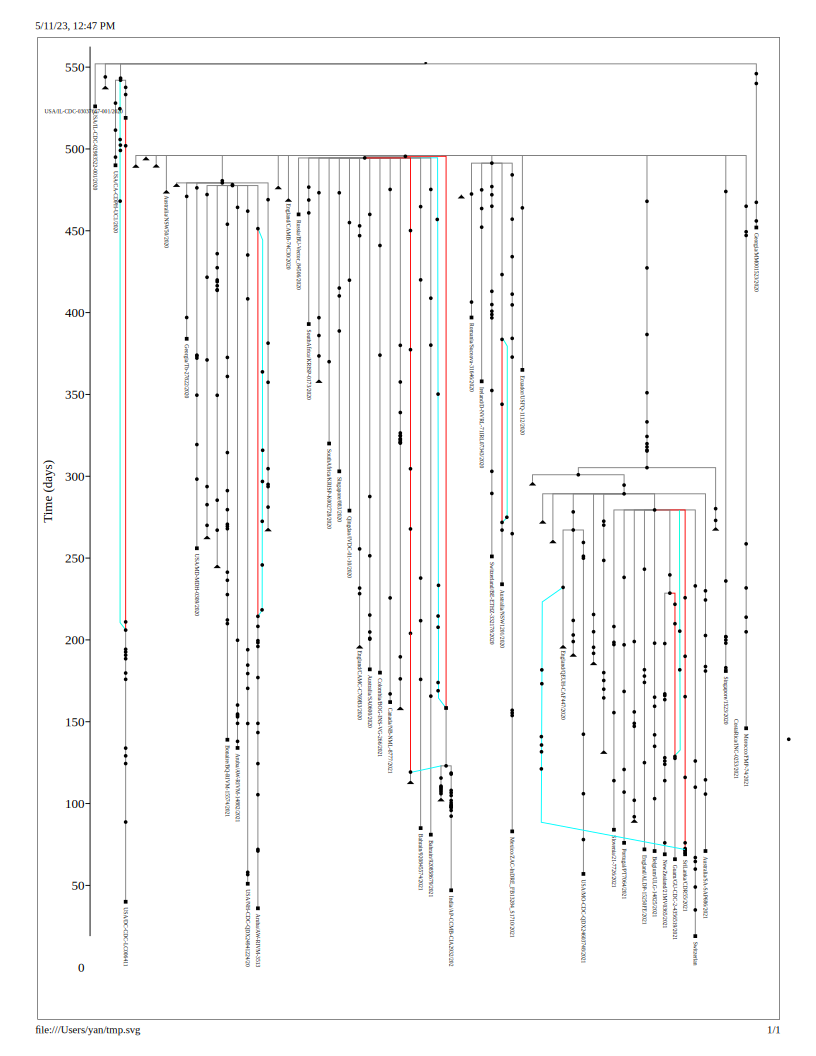

In [20]:
from IPython.display import SVG
SVG(filename="nxstr-simplified-ARG.svg")